# modeling.ipynb - Arrest Prediction 

**Goal:** Predict whether an incident results in an arrest (arrest 0/1).

**Input:** data/processed/model_input.csv (from feature_engineering.ipynb).
Output: Trained model + evaluation report + saved artifacts in models/.

In [1]:
# Core
import os, json, joblib, numpy as np, pandas as pd 
from pathlib import Path 

# Modeling 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Plots
import matplotlib.pyplot as plt

# Paths 
REPO = Path.cwd()
while REPO.name != "chicago-crime-pipeline" and REPO.parent != REPO:
    REPO = REPO.parent
DATA = REPO / "data" / "processed"
MODELS_DIR = REPO / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

DATA

PosixPath('/Volumes/easystore/Projects/chicago-crime-pipeline/data/processed')

In [2]:
# Load the data 
df = pd.read_csv(DATA / "arrest_features.csv")
print(df.shape)
df.head()

# Sanity checks 
assert "arrest" in df.columns, "Target column 'arrest' missing"
print(df['arrest'].value_counts(dropna=False))
print(df.isna().mean().sort_values(ascending=False).head(10))

(5694, 10)
arrest
0    4809
1     885
Name: count, dtype: int64
id                      0.0
date                    0.0
primary_type            0.0
location_description    0.0
arrest                  0.0
location_grouped        0.0
year                    0.0
month                   0.0
dow                     0.0
hour                    0.0
dtype: float64


In [3]:
# Split train/test

TARGET = 'arrest'

y = df[TARGET].astype(int).values
X = df.drop(columns=[TARGET]).copy()

# Identify feature types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number', 'bool']).columns.to_list()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

Categorical: ['date', 'primary_type', 'location_description', 'location_grouped']
Numeric: ['id', 'year', 'month', 'dow', 'hour']


((4555, 9), (1139, 9))

In [4]:
# Preprocessor (OneHot for categoricals, passthrough numeric)
pre = ColumnTransformer(
    transformers = [
("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
("num", "passthrough", num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

## Baseline Model: Logistic Regression 

In [5]:
logit = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=1000, class_weight="balanced", n_jobs=None, solver="lbfgs"
    ))
])

logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Average Precision (PR-AUC):", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

ROC-AUC: 0.7486462994937569
Average Precision (PR-AUC): 0.5002375757052318
              precision    recall  f1-score   support

           0      0.920     0.704     0.797       962
           1      0.293     0.667     0.407       177

    accuracy                          0.698      1139
   macro avg      0.606     0.685     0.602      1139
weighted avg      0.822     0.698     0.737      1139



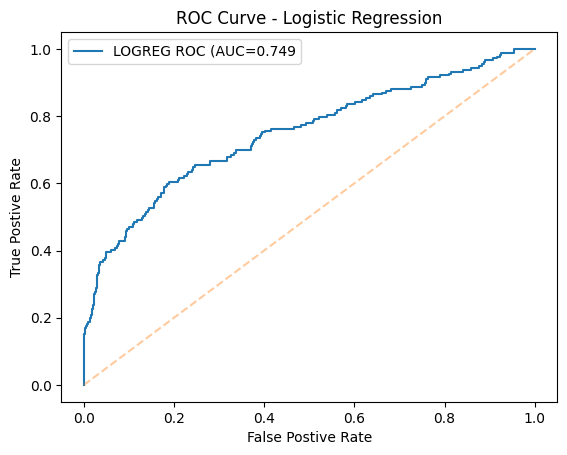

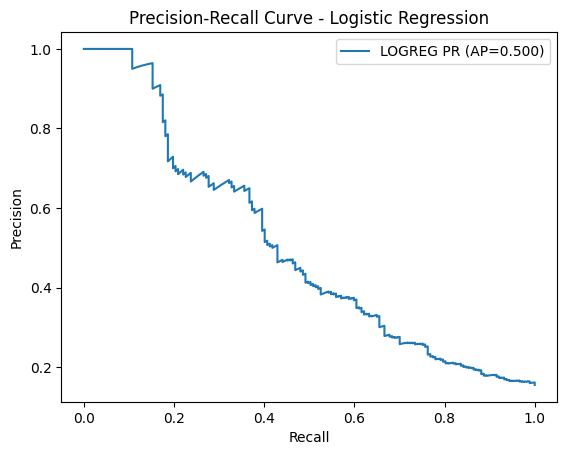

In [7]:
 # Plot ROC and PR curves for Logistic Regression 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

plt.Figure()
plt.plot(fpr, tpr, label=f"LOGREG ROC (AUC={auc(fpr, tpr):.3f}")
plt.plot([0,1],[0,1], "--", alpha=0.4)
plt.xlabel("False Postive Rate"); plt.ylabel("True Postive Rate")
plt.title("ROC Curve - Logistic Regression"); plt.legend(); plt.show()

plt.figure()
ap = average_precision_score(y_test, y_proba)
plt.plot(rec, prec, label=f"LOGREG PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression"); plt.legend(); plt.show()

### ROC & PR Curves — Logistic Regression

- ROC-AUC = 0.75 → model distinguishes arrests vs non-arrests ~75% of the time.  
- PR-AUC = 0.50 vs baseline 0.15 → ~3× improvement over random chance.  
- Model adds real value, but there’s a trade-off: we must choose a threshold that balances false alarms vs missed arrests.